In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from google.colab import files 
import matplotlib.pyplot as plt

# **Get The Kaggle Dataset**

[Dataset Link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

Get the Kaggle API KEY as mentioned in the [steps](https://www.kaggle.com/docs/api#authentication)

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"<username>","key":"<api_key>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

# **Download The Dataset**

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:01<00:00, 41.3MB/s]
100% 2.29G/2.29G [01:01<00:00, 40.3MB/s]


**Unzip The dataset**

In [ ]:
!unzip 'chest-xray-pneumonia.zip' -d chest-xray-pneumonia

# **Preprocess and analysis**

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
	rescale=1./255,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# Train generator for train folder
train_generator = datagen.flow_from_directory(
    "chest-xray-pneumonia/chest_xray/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

# Test generator for test folder
test_generator = datagen.flow_from_directory(
    "chest-xray-pneumonia/chest_xray/test",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

# validation generator for val folder
val_generator = datagen.flow_from_directory(
    "chest-xray-pneumonia/chest_xray/val",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# **Create the MobileNetV2 CNN model**

**We are creating a CNN model using keras with input shape as (224,224,3) which stands for 35x35 RGB pictures . Refer [link](https://keras.io/api/layers/convolution_layers/convolution2d/)**


In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
predictions = tf.keras.layers.Dense(2,activation='sigmoid')(x)
model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

94668760/94668760 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

**Training the Keras Model**

In [ ]:
epochs = 8

checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=test_generator, 
                    validation_steps=len(test_generator),
                    callbacks=[checkpoint])

Epoch 1/8
82/82 [==============================] - 123s 1s/step - loss: 0.2253 - accuracy: 0.9036 - val_loss: 0.5531 - val_accuracy: 0.7885
Epoch 2/8
82/82 [==============================] - 107s 1s/step - loss: 0.1459 - accuracy: 0.9440 - val_loss: 0.5157 - val_accuracy: 0.8253
Epoch 3/8
82/82 [==============================] - 107s 1s/step - loss: 0.1346 - accuracy: 0.9479 - val_loss: 0.4396 - val_accuracy: 0.8429
Epoch 4/8
82/82 [==============================] - 107s 1s/step - loss: 0.1238 - accuracy: 0.9557 - val_loss: 0.5192 - val_accuracy: 0.8173
Epoch 5/8
82/82 [==============================] - 108s 1s/step - loss: 0.1217 - accuracy: 0.9538 - val_loss: 0.4083 - val_accuracy: 0.8750
Epoch 6/8
82/82 [==============================] - 106s 1s/step - loss: 0.1129 - accuracy: 0.9578 - val_loss: 0.4245 - val_accuracy: 0.8574
Epoch 7/8
82/82 [==============================] - 107s 1s/step - loss: 0.1125 - accuracy: 0.9567 - val_loss: 0.4304 - val_accuracy: 0.8542
Epoch 8/8
82/82 [===

# **Loss and Accuracy Curves**

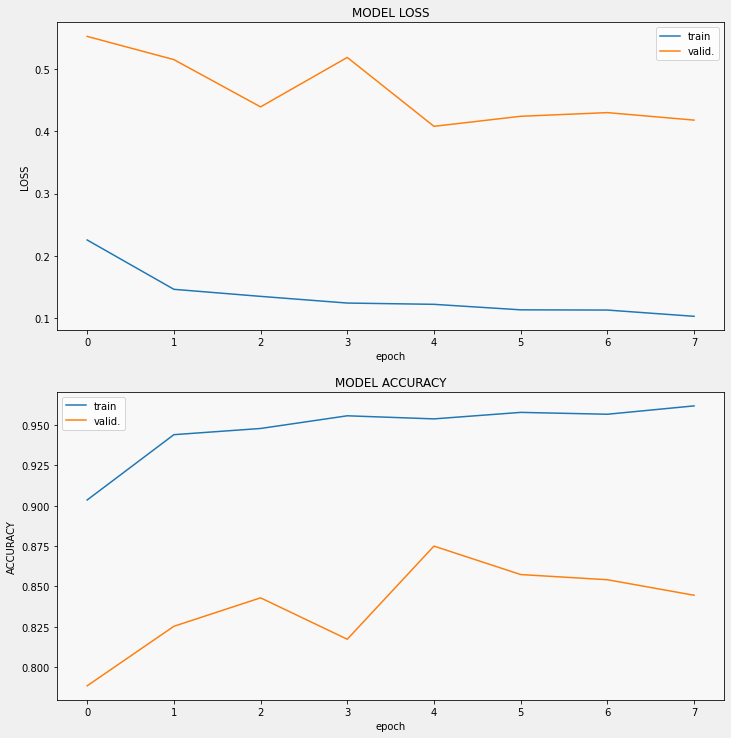

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)

display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'ACCURACY',
    212,
)


# **Accuracy**

Checking Accuracy with respect to the test data

In [ ]:
score = model.evaluate(test_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

10/10 [==============================] - 11s 1s/step - loss: 0.3888 - accuracy: 0.8622
Accuracy: 86.22%
Loss:  0.38875627517700195


Checking Accuracy with respect to the validation data

In [ ]:
score = model.evaluate(val_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

1/1 [==============================] - 1s 1s/step - loss: 0.2205 - accuracy: 0.8125
Accuracy: 81.25%
Loss:  0.22048616409301758


# **Fine tuning The Model**

In [ ]:
resnet_model.trainable = True
print("Number of layers in the base model: ", len(resnet_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()

Number of layers in the base model:  190
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                     

In [ ]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

86

In [ ]:
epochs =  9


checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

history_fine = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=test_generator, 
                    validation_steps=len(test_generator),
                    callbacks=[checkpoint])

Epoch 1/8
82/82 [==============================] - 125s 1s/step - loss: 0.1753 - accuracy: 0.9404 - val_loss: 62.2026 - val_accuracy: 0.5593
Epoch 2/8
82/82 [==============================] - 111s 1s/step - loss: 0.0877 - accuracy: 0.9697 - val_loss: 4.5533 - val_accuracy: 0.6426
Epoch 3/8
82/82 [==============================] - 110s 1s/step - loss: 0.0732 - accuracy: 0.9707 - val_loss: 0.3853 - val_accuracy: 0.9038
Epoch 4/8
82/82 [==============================] - 111s 1s/step - loss: 0.0664 - accuracy: 0.9747 - val_loss: 1.1846 - val_accuracy: 0.8478
Epoch 5/8
82/82 [==============================] - 111s 1s/step - loss: 0.0582 - accuracy: 0.9801 - val_loss: 0.4438 - val_accuracy: 0.9071
Epoch 6/8
82/82 [==============================] - 110s 1s/step - loss: 0.0537 - accuracy: 0.9812 - val_loss: 0.6813 - val_accuracy: 0.8269
Epoch 7/8
82/82 [==============================] - 111s 1s/step - loss: 0.0503 - accuracy: 0.9829 - val_loss: 0.3036 - val_accuracy: 0.9103
Epoch 8/8
82/82 [==

**Test With Respect to the validation Function**

In [ ]:
score = model.evaluate(val_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

1/1 [==============================] - 0s 356ms/step - loss: 0.0194 - accuracy: 1.0000
Accuracy: 100.00%
Loss:  0.019394932314753532


# **Save The Model**

Refer the [docs](https://www.tensorflow.org/guide/keras/save_and_serialize) from the Tensorflow

In [ ]:
!mkdir '/content/model'
model.save('/content/model')

# **Model To TFLITE**

**Using [Python API](https://www.tensorflow.org/lite/models/convert/convert_models) (Recommended Approach) we convert the Keras Model to TLITE** 

This TFLITE model will be deployed to our [Android App](https://github.com/generic-matrix/android-face-mask-detection) 

In [ ]:
!mkdir '/content/tflite'
saved_model_dir = '/content/model'
tflite_model_path = '/content/tflite/model.tflite'
# Convert the model
# path to the SavedModel directory
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

Added FP16 quantization

In [ ]:
saved_model_dir = '/content/model'
tflite_model_path = '/content/tflite/model-optimized.tflite'
# Convert the model
# path to the SavedModel directory
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 

# For FP16 quantization:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)